In [39]:
%reload_ext autoreload
%autoreload 2 
    
import pandas as pd
import numpy as np
import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, Hyperband, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

from DataEncoder import encode_pad_event, encode_pad_sequence, encode_y, encode_textual_event
from DurationEmbedding import duration_embedding_layer
from FeatureEmbedding import feature_embedding_layer
#from DurationEmbeddingLSTM import DurationEmbeddingLSTMModel, print_best_hp_duration
from TextFeatureDurationEmbeddingLSTMIm import TextFeatureDurationEmbeddingLSTMModel, print_best_hp_duration_text
from utils import plot_training_history_LSTMim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [20]:
event = pd.read_csv("D:/Research in UAE/sequence/output/Event_Feature_pro.csv")
sequence = pd.read_csv("D:/Research in UAE/sequence/output/Sequence_Feature_pro.csv")
event_duration_embedding = pd.read_csv("D:/Research in UAE/sequence/output/Event_Duration_Embedding_pro.csv")
event_feature_embedding = pd.read_csv("D:/Research in UAE/sequence/output/Event_feature_Embedding_pro.csv")

In [21]:
y_col = sequence.result
y_encode = encode_y(y_col)

In [22]:
cat_col_event = ['Resource', 'outcome', "stopcode"]
num_col_event = ['net_promotor_score', 'creditscore', 'rate_charged']
case_index = 'Case ID'

event_encode = encode_pad_event(event, cat_col_event, num_col_event, case_index, cat_mask = True, num_mask = True, eos = False)

In [23]:
cat_col_seq = ['plan']
num_col_seq = ['age', 'coverage_numeric', 'length_of_stay']
sequence_encode = encode_pad_sequence(sequence, cat_col_seq, num_col_seq,  cat_mask = False, num_mask = False)

In [24]:
event_duration_embedding_names = event_duration_embedding.columns.to_list()
embedding_duration_cols_names = event_duration_embedding_names[7:]
duration_embedding_encode = duration_embedding_layer(event_duration_embedding, embedding_duration_cols_names, case_index, eos = False)

In [25]:
event_feature_embedding_names = event_feature_embedding.columns.to_list()
embedding_feature_cols_names = event_feature_embedding_names[5:]
feature_embedding_encode = feature_embedding_layer(event_feature_embedding, embedding_feature_cols_names, case_index, eos = False)

In [26]:
verb_encode, verb_size = encode_textual_event(event, 'Activity_verb', case_index, eos = False)
dec_encode, dec_size = encode_textual_event(event, 'Activity_Dec', case_index, eos = False)

In [27]:
# Define the input shape (sequence_length, number_of_features)
event_input_shape = (event_encode.shape[1], event_encode.shape[2])

# Define the number of classes 
num_classes = y_encode.shape[1]

# number of sequence features
num_sequence_features = sequence_encode.shape[1]

duration_embedding_shape = (duration_embedding_encode.shape[1], duration_embedding_encode.shape[2])
feature_embedding_shape = (feature_embedding_encode.shape[1], feature_embedding_encode.shape[2])

# make sure the event_encode.shape[1] = duration(feature)_embedding_encode.shape[1] = verb(dec)encode.shape[1] 
sequence_size = event_encode.shape[1]

In [33]:
# Split indices for train and test
train_indices, test_indices = train_test_split(np.arange(len(y_encode)), test_size=0.2, stratify=y_encode, random_state=42)

# Split the data
train_event_features = event_encode[train_indices]
test_event_features = event_encode[test_indices]

train_sequence_features = sequence_encode[train_indices]
test_sequence_features = sequence_encode[test_indices]

train_y = y_encode[train_indices]
test_y = y_encode[test_indices]

train_duration_embedding = duration_embedding_encode[train_indices]
test_duration_embedding = duration_embedding_encode[test_indices]

train_feature_embedding = feature_embedding_encode[train_indices]
test_feature_embedding = feature_embedding_encode[test_indices]

train_verb_encode = verb_encode[train_indices]
train_dec_encode = dec_encode[train_indices]

test_verb_encode = verb_encode[test_indices]
test_dec_encode = dec_encode[test_indices]

In [34]:
# Include batch size as a hyperparameter to be tuned
hp_b = HyperParameters()
batch_size = hp_b.Choice('batch_size', values=[16, 32, 64, 128])

In [36]:
#Initialize the hypermodel
hypermodel = TextFeatureDurationEmbeddingLSTMModel(sequence_size = sequence_size, 
                                                   verb_size = verb_size, 
                                                   dec_size = dec_size,
                                                   event_input_shape = event_input_shape,
                                                   num_sequence_features = num_sequence_features,
                                                   feature_embedding_shape = feature_embedding_shape,
                                                   duration_embedding_shape = duration_embedding_shape,
                                                   num_classes=num_classes)

early_stopping = EarlyStopping(monitor='val_f1_score',  
                               mode='max',
                               patience=5, 
                               restore_best_weights=True)

tuner_band = Hyperband(hypermodel,
                       objective=kt.Objective("val_f1_score", direction="max"),
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_feature_text_hyperband_im',
                       hyperparameters=hp_b)

# Use the manually split data in the search
tuner_band.search(x=[train_verb_encode, train_dec_encode, train_event_features, train_feature_embedding, train_duration_embedding, train_sequence_features], y=train_y, 
                  validation_data=([test_verb_encode, test_dec_encode, test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features], test_y), 
                  epochs=200, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model_band = tuner_band.get_best_models(num_models=1)[0]

Trial 254 Complete [00h 03m 35s]
val_f1_score: 0.8468296527862549

Best val_f1_score So Far: 0.8625187873840332
Total elapsed time: 05h 10m 17s


In [41]:
# Get predictions
y_pred_probs = best_model_band.predict([test_verb_encode, test_dec_encode, test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features])
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(test_y, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute Classification Report
class_report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 92   0   0   0   0   0]
 [  0 173   0   0   1   0]
 [  0   0   4   1   0   0]
 [  0   0   1  20   0   0]
 [  0   5   0   0  27   0]
 [  0  45   0   0   2  57]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        92
           1     0.7758    0.9943    0.8715       174
           2     0.8000    0.8000    0.8000         5
           3     0.9524    0.9524    0.9524        21
           4     0.9000    0.8438    0.8710        32
           5     1.0000    0.5481    0.7081       104

    accuracy                         0.8715       428
   macro avg     0.9047    0.8564    0.8672       428
weighted avg     0.8967    0.8715    0.8625       428



Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - f1_score: 0.8112 - loss: 0.5835 - val_f1_score: 0.8524 - val_loss: 0.4564
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - f1_score: 0.8031 - loss: 0.5587 - val_f1_score: 0.8595 - val_loss: 0.4769
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - f1_score: 0.8082 - loss: 0.5696 - val_f1_score: 0.8396 - val_loss: 0.5181
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - f1_score: 0.8177 - loss: 0.5625 - val_f1_score: 0.8476 - val_loss: 0.5515
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - f1_score: 0.8207 - loss: 0.5669 - val_f1_score: 0.8371 - val_loss: 0.4857
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - f1_score: 0.8226 - loss: 0.5311 - val_f1_score: 0.8563 - val_loss: 0.4604
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - f1_score: 0.8257 - loss: 0.5227 - val_f1_score: 0.8568 - val_loss: 0.4475
Best epoch: 2
Best F1 Score:  0.8594691753387451
Best hyperparameters found were:
Number of Verb

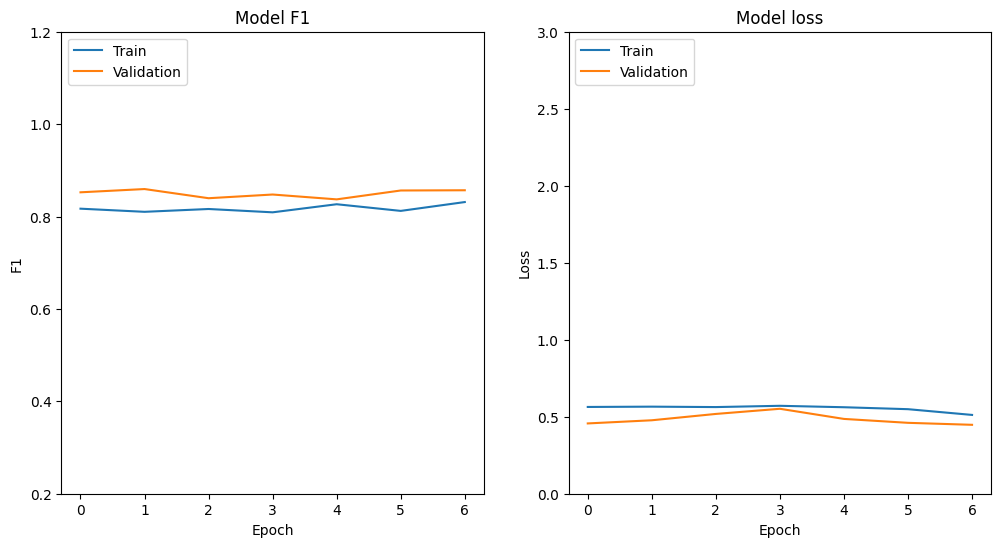

In [42]:
# alternatively, build the model with the optimal hyperparameters 
# best_model_band  = band_tuner.hypermodel.build(best_hps_band)
history_band = best_model_band.fit(x=[train_verb_encode, train_dec_encode, train_event_features, train_feature_embedding, train_duration_embedding, train_sequence_features], y=train_y, 
                                   validation_data=([test_verb_encode, test_dec_encode, test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features], test_y), 
                                   epochs=200, batch_size=best_hps_band.get('batch_size'), callbacks=[early_stopping])

val_acc_per_epoch_band = history_band.history['val_f1_score']
best_epoch_band = val_acc_per_epoch_band.index(max(val_acc_per_epoch_band)) + 1
print('Best epoch: %d' % (best_epoch_band,))
print('Best F1 Score: ', max(val_acc_per_epoch_band))

print_best_hp_duration_text(best_hps_band)
plot_training_history_LSTMim(history_band.history)

In [16]:
def print_best_hp_duration_text(best_hps):
    print("Best hyperparameters found were:")
    
    print(f"Number of Verb Embedding dim: {best_hps.get('verb_embedding_dim')}")
    print(f"Number of Dec Embedding dim: {best_hps.get('dec_embedding_dim')}")

    print(f"Number of Verb-dec LSTM layers: {best_hps.get('verb_dec_num_lstm_layers')}")
    for r in range(best_hps.get('verb_dec_num_lstm_layers')):
        print(f"  LSTM Layer {r}:")
        print(f"    Units: {best_hps.get('verb_dec_lstm_units_l' + str(r))}")
        print(f"    Dropout Rate: {best_hps.get('verb_dec_dropout_l' + str(r))}")
        print(f"    L2 Regularization: {best_hps.get('verb_dec_l2_reg_l' + str(r))}")
        if best_hps.get('verb_dec_batch_norm_l' + str(r)):
            print(f"    Batch Norm Momentum: {best_hps.get('verb_dec_batch_norm_momentum_' + str(r))}")
            print(f"    Batch Norm Epsilon: {best_hps.get('verb_dec_batch_norm_epsilon_' + str(r))}")
    
    print(f"Number of Event LSTM layers: {best_hps.get('event_num_lstm_layers')}")
    for i in range(best_hps.get('event_num_lstm_layers')):
        print(f"  LSTM Layer {i}:")
        print(f"    Units: {best_hps.get('event_lstm_units_l' + str(i))}")
        print(f"    Dropout Rate: {best_hps.get('event_dropout_l' + str(i))}")
        print(f"    L2 Regularization: {best_hps.get('event_l2_reg_l' + str(i))}")
        if best_hps.get('event_batch_norm_l' + str(i)):
            print(f"    Batch Norm Momentum: {best_hps.get('event_batch_norm_momentum_' + str(i))}")
            print(f"    Batch Norm Epsilon: {best_hps.get('event_batch_norm_epsilon_' + str(i))}")
    
    print(f"Number of Feature LSTM layers: {best_hps.get('feature_num_lstm_layers')}")
    for k in range(best_hps.get('feature_num_lstm_layers')):
        print(f"  LSTM Layer {k}:")
        print(f"    Units: {best_hps.get('feature_lstm_units_l' + str(k))}")
        print(f"    Dropout Rate: {best_hps.get('feature_dropout_l' + str(k))}")
        print(f"    L2 Regularization: {best_hps.get('feature_l2_reg_l' + str(k))}")
        if best_hps.get('feature_batch_norm_l' + str(k)):
            print(f"    Batch Norm Momentum: {best_hps.get('feature_batch_norm_momentum_' + str(k))}")
            print(f"    Batch Norm Epsilon: {best_hps.get('feature_batch_norm_epsilon_' + str(k))}")
    
    print(f"Number of Duration Embedding LSTM layers: {best_hps.get('duration_num_lstm_layers')}")
    for m in range(best_hps.get('duration_num_lstm_layers')):
        print(f"  LSTM Layer {m}:")
        print(f"    Units: {best_hps.get('duration_lstm_units_l' + str(m))}")
        print(f"    Dropout Rate: {best_hps.get('duration_dropout_l' + str(m))}")
        print(f"    L2 Regularization: {best_hps.get('duration_l2_reg_l' + str(m))}")
        if best_hps.get('duration_batch_norm_l' + str(m)):
            print(f"    Batch Norm Momentum: {best_hps.get('duration_batch_norm_momentum_' + str(m))}")
            print(f"    Batch Norm Epsilon: {best_hps.get('duration_batch_norm_epsilon_' + str(m))}")
    
    print(f"Number of Concatenate Event Feature LSTM layers: {best_hps.get('concat_num_lstm_layers')}")
    for n in range(best_hps.get('concat_num_lstm_layers')):
        print(f"  LSTM Layer {n}:")
        print(f"    Units: {best_hps.get('concat_lstm_units_l' + str(n))}")
        print(f"    Dropout Rate: {best_hps.get('concat_dropout_l' + str(n))}")
        print(f"    L2 Regularization: {best_hps.get('concat_l2_reg_l' + str(n))}")
        if best_hps.get('concat_batch_norm_l' + str(n)):
            print(f"    Batch Norm Momentum: {best_hps.get('concat_batch_norm_momentum_' + str(n))}")
            print(f"    Batch Norm Epsilon: {best_hps.get('concat_batch_norm_epsilon_' + str(n))}")
    
    print(f"Number of Dense layers: {best_hps.get('num_dense_layers')}")
    for j in range(best_hps.get('num_dense_layers')):
        print(f"  Dense Layer {j}:")
        print(f"    Units: {best_hps.get('dense_units_' + str(j))}")
        print(f"    Activation: {best_hps.get('dense_activation_' + str(j))}")
        if best_hps.get('dense_activation_' + str(j)) == 'leaky_relu':
            print(f"    Leaky ReLU Alpha: {best_hps.get('leaky_alpha_' + str(j))}")
        print(f"    Dropout Rate: {best_hps.get('dropout_dense_' + str(j))}")
        print(f"    L2 Regularization: {best_hps.get('l2_dense_' + str(j))}")
    
    print(f"Optimizer: {best_hps.get('optimizer')}")
    if best_hps.get('optimizer') == 'adam':
        print(f"  Learning Rate (Adam): {best_hps.get('init_lr')}")
        print(f"  Beta 1 (Adam): {best_hps.get('adam_beta_1')}")
        print(f"  Beta 2 (Adam): {best_hps.get('adam_beta_2')}")
    elif best_hps.get('optimizer') == 'sgd':
        print(f"  Learning Rate (SGD): {best_hps.get('init_lr')}")
        print(f"  Momentum (SGD): {best_hps.get('sgd_momentum')}")
    elif best_hps.get('optimizer') == 'rmsprop':
        print(f"  Learning Rate (RMSprop): {best_hps.get('init_lr')}")

    print(f"Learning Rate Schedule: {best_hps.get('lr_schedule_type')}")
    print('Best batch size:', best_hps.get('batch_size'))
    
print_best_hp_duration_text(best_hps_band)

Best hyperparameters found were:
Number of Verb Embedding dim: 20
Number of Dec Embedding dim: 30
Number of Verb-dec LSTM layers: 3
  LSTM Layer 0:
    Units: 256
    Dropout Rate: 0.23717032262586338
    L2 Regularization: 0.0023925396156713676
    Batch Norm Momentum: 0.01
    Batch Norm Epsilon: 3.7469802878172694e-05
  LSTM Layer 1:
    Units: 32
    Dropout Rate: 0.3389871771344775
    L2 Regularization: 0.0005918848280709438
  LSTM Layer 2:
    Units: 224
    Dropout Rate: 0.24344136773794794
    L2 Regularization: 5.1834342773010556e-05
Number of Event LSTM layers: 3
  LSTM Layer 0:
    Units: 96
    Dropout Rate: 0.3519458537931246
    L2 Regularization: 0.0018596704202191385
  LSTM Layer 1:
    Units: 256
    Dropout Rate: 0.37675340065863155
    L2 Regularization: 2.5045331013089763e-05
    Batch Norm Momentum: 0.81
    Batch Norm Epsilon: 0.0005416857992682692
  LSTM Layer 2:
    Units: 224
    Dropout Rate: 0.24071182906408456
    L2 Regularization: 0.00018409254478428912
 

In [ ]:
for key, value in best_hps_band.values.items():        
    print(f"{key}: {value}")

In [ ]:
# RandomSearch
tuner_rand= RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=2,
    directory='hparam_tuning',
    project_name='classfication_2levelfeatures_rand',
    hyperparameters=hp_b
)

tuner_rand.search(x=[verb_encode, dec_encode, event_encode, feature_embedding_encode, duration_embedding_encode, sequence_encode], y = y_encode,\
             epochs=300, validation_split=0.2, callbacks=[early_stopping])

# Get the best models and hyperparameters after search is randed
best_model_rand = tuner_rand.get_best_models(num_models=1)[0]
best_hps_rand = tuner_rand.get_best_hyperparameters(num_trials=1)[0]

# Fit the best model with the optimal batch size
best_model_rand.fit(
    [event_encode, sequence_encode],
    y_encode,
    epochs=300,
    batch_size=best_hps_rand.get('batch_size'),  # Use the best batch size found
    validation_split=0.2
)

# Evaluate the best model
loss, accuracy = best_model_rand.evaluate([verb_encode, dec_encode, event_encode,  feature_embedding_encode, duration_embedding_encode, sequence_encode], y_encode)
print('Test accuracy:', accuracy)
print_best_hp(best_hps_rand)
#print_best_hp(best_hps)
best_model_rand.summary()

In [17]:
def psedudo_embedding_lstm_model(sequence_size, verb_size, dec_size, event_input_shape, feature_embedding_shape, duration_embedding_shape, num_sequence_features, num_classes, lstm_units=128, dropout_rate = 0.2):
    
    """
    Create and compile an LSTM model for classification.
    
    Parameters:
    - event_input_shape: Tuple representing the shape of the input data (sequence_length, number_of_features).
    - duration_embedding_shape: Tuple representing the shape of the embedding layers (sequence_length, number_of_features)
    - num_sequence_features: Interger represnting the number of sequence level feature
    - num_classes: Integer representing the number of target classes.
    - lstm_units: Integer representing the number of units in LSTM layers.
    - dropout_rate: Float between 0 and 1 representing the dropout rate for regularization.
    
    Returns:
    - Compiled Keras model ready for training.
    """    
    verb_embedding_dim = 50
    dec_embedding_dim = 50
    # Inputs
    verb_input = Input(shape=(sequence_size,), dtype='int32', name='verb_input')
    dec_input = Input(shape=(sequence_size,), dtype='int32', name='dec_input')
    # Embeddings
    verb_embedding= Embedding(verb_size, verb_embedding_dim, mask_zero=True)(verb_input)
    dec_embedding = Embedding(dec_size, dec_embedding_dim, mask_zero=True)(dec_input)

    # Combine embeddings using concatenation
    verb_dec_embedding = Concatenate()([verb_embedding, dec_embedding])

    # LSTM layer
    verb_dec_lstm_out = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.02))(verb_dec_embedding)
    verb_dec_lstm_out = Dropout(dropout_rate)(verb_dec_lstm_out)

    # Event-level input: Sequential data for LSTM processing
    event_input = Input(shape= event_input_shape, name='event_input')
    x = Masking(mask_value=-1.0)(event_input)
    # LSTM layers processing event-level features
    #lstm0_out = LSTM(lstm_units, return_sequences=True)(event_input)
    event_lstm_out = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.02))(x)
    event_lstm_out = Dropout(dropout_rate)(event_lstm_out)
    #lstm1_out = LSTM(int(lstm_units / 2), return_sequences=True)(lstm0_out)
    #lstm1_out = Dropout(dropout_rate)(lstm1_out)
    # Additional LSTM layer
    #lstm_out = LSTM(int(lstm_units / 2), return_sequences=False, kernel_regularizer=l2(0.02))(lstm0_out)  # Set return_sequences=False on the last LSTM layer
    #lstm_out = Dropout(dropout_rate)(lstm_out)
    # duration-embedding input: Additional embedding input data
    feature_embedding_input = Input(shape = feature_embedding_shape, name='feature_embedding_input')
    feature_embedding_lstm_out = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.02))(feature_embedding_input)
    feature_embedding_lstm_out = Dropout(dropout_rate)(feature_embedding_lstm_out)

    duration_embedding_input = Input(shape = duration_embedding_shape, name='duration_embedding_input')
    duration_embedding_lstm_out = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.02))(duration_embedding_input)
    duration_embedding_lstm_out = Dropout(dropout_rate)(duration_embedding_lstm_out)

    
    # Concatenate the outputs of the initial LSTM layers
    combined_lstm_out = Concatenate()([verb_dec_lstm_out, event_lstm_out, feature_embedding_lstm_out, duration_embedding_lstm_out])

    # Additional LSTM layer after combining event and duration-embedding outputs
    combined_lstm_final_out = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(0.02))(combined_lstm_out)
    combined_lstm_final_out = Dropout(dropout_rate)(combined_lstm_final_out)
    

    # Sequence-level input: Static context features for the whole sequence
    sequence_input = Input(shape=(num_sequence_features,), name='sequence_input')

    # Concatenate LSTM output with sequence-level features
    concatenated = Concatenate()([combined_lstm_final_out, sequence_input])

    # Dense layer(s) after concatenation
    dense0_out = Dense(lstm_units, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
    dense0_out = Dropout(dropout_rate)(dense0_out)
    #dense1_out = Dense(int(lstm_units/2), activation='relu')(dense0_out)  # Additional dense layer
    #dense1_out = Dropout(dropout_rate)(dense1_out)
    #dense_out = Dense(int(lstm_units/4), activation='relu')(dense1_out)  # Additional dense layer
    #dense_out = Dropout(dropout_rate)(dense_out)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dense0_out)

    # Build and compile the model
    model = Model(inputs=[verb_input, dec_input, event_input, feature_embedding_input, duration_embedding_input, sequence_input], outputs=output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
model = psedudo_embedding_lstm_model(sequence_size, verb_size, dec_size, event_input_shape, feature_embedding_shape, duration_embedding_shape, num_sequence_features, num_classes, lstm_units=256, dropout_rate = 0.5)
history = model.fit([verb_encode, dec_encode, event_encode, feature_embedding_encode, duration_embedding_encode, sequence_encode],y_encode, epochs=300, batch_size=16, validation_split=0.2)

Epoch 1/300
 37/108 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4880 - loss: 23.5097

KeyboardInterrupt: 

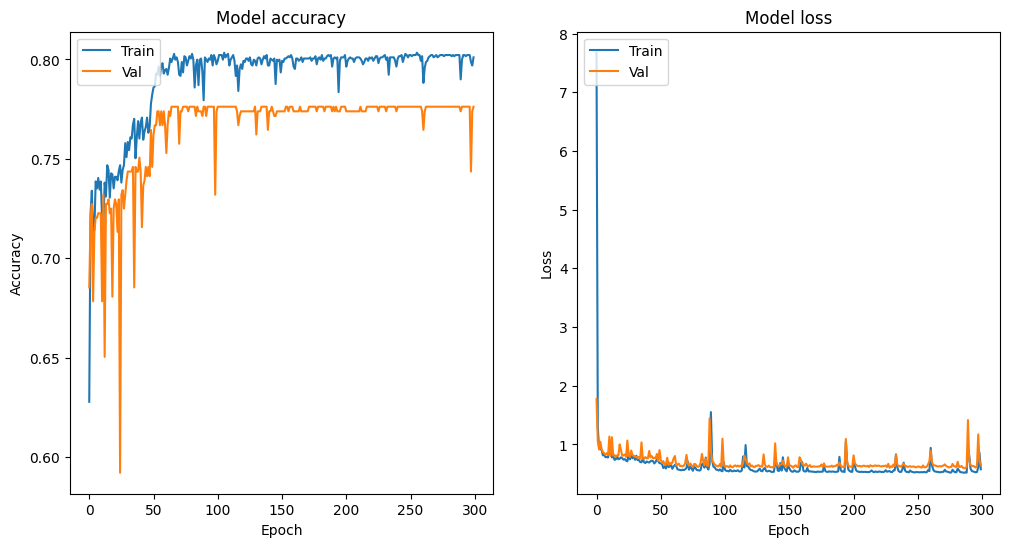

In [37]:
plot_training_history(history)

In [ ]:
plot_training_history_smooth(history)